In [2]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

## Load all data

In [3]:
df_ta_all = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/data/ta_obs.csv')
df_ta_all['Date'] = pd.to_datetime(df_ta_all[['Year','Month','Day']])

df_p_all = pd.read_csv('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/data/p_obs.csv')
df_p_all['Date'] = pd.to_datetime(df_p_all[['Year','Month','Day']], errors='coerce')

invalid_dates = df_p_all[df_p_all['Date'].isna()]

for idx, row in invalid_dates.iterrows():
    non_nas = row.dropna()
    msg = f"Dropping row {idx} due to invalid date. Non-NA values:"
    for col, val in non_nas.items():
        msg += f" {col}={val};"
    print(msg)

# drop rows w invalid dates
df_p_all = df_p_all[df_p_all['Date'].notna()]

Dropping row 6795 due to invalid date. Non-NA values: Year=1818; Month=2; Day=29; Schaffhausen=977.8;


In [4]:
## already assimilated stations
with open('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/data/ispd_names.txt','r') as f:
    ispd_names = f.readlines()
ispd_names = [x.strip() for x in ispd_names[1:]]

## create segments

In [5]:
# Function to extract continuous non-NaN segments
def get_segments(df, date_col='Date'):
    segments = []

    # make sure index is 'Date'
    if df.index.name != 'Date':
        df = df.set_index(['Date'])
        df = df.drop(columns={'Year','Month','Day'})
        # raise ValueError("'Date' must be set as the index of dataframe.")
    
    for station in df.columns:
        data = df[[station]].dropna().reset_index()
        if not data.empty:
            # Identify breaks in the sequence
            data['gap'] = data[date_col].diff().dt.days.ne(1).cumsum()
            for _, group in data.groupby('gap'):
                segments.append((station, group['Date'].iloc[0], group['Date'].iloc[-1]))
    return segments

# Get the actual non-NaN segments
segments_ta       = get_segments(df_ta_all)
segments_p        = get_segments(df_p_all)

# unique station names
stations_ta       = set([s[0] for s in segments_ta])
stations_p        = set([s[0] for s in segments_p])

stations_all = sorted(set(stations_ta | stations_p),
                      reverse=True)

# availability plot

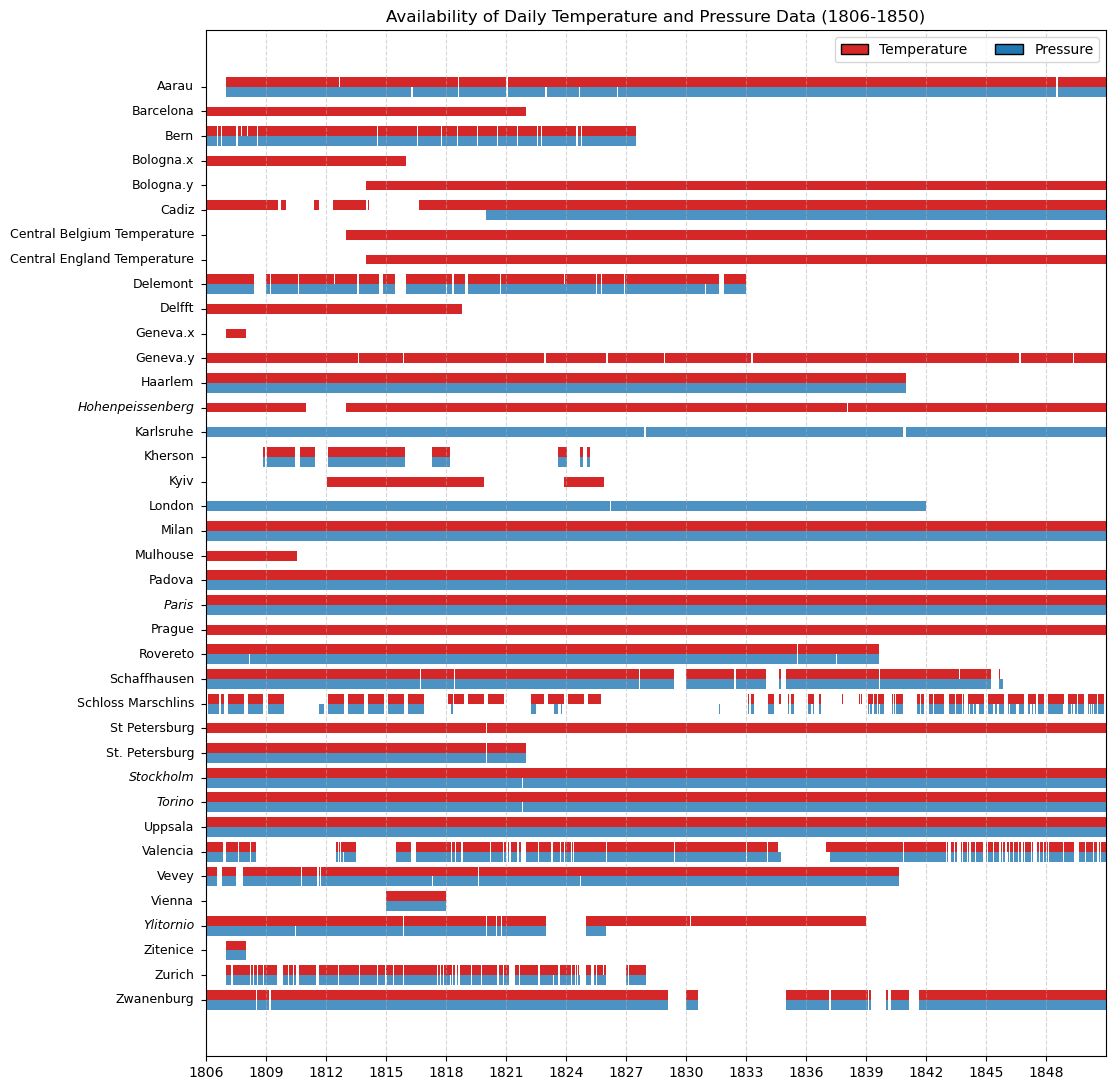

In [9]:
offset = 0.4  # Base offset
station_positions = {station: i for i, station in enumerate(stations_all)}

fig, ax = plt.subplots(figsize=(12, len(stations_all) * 0.3))
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)  # More space on the left, less on the right, top, and bottom

ax.set_xlim(pd.Timestamp("1806-01-01"), pd.Timestamp("1850-12-31"))

# Plot Pressure Data
for station, start, end in segments_p:
    # Shift down if both temperature and pressure exist
    position = station_positions[station] if station not in (stations_ta) else station_positions[station] - offset / 2
    ax.barh(position, width=(end - start).days, left=start,
            color='tab:blue', height=.4, align='center', alpha=0.8)

# Plot Temperature Data
for station, start, end in segments_ta:
    # Shift up if both temperature and pressure exist
    position = station_positions[station] if station not in (stations_p) else station_positions[station] + offset / 2
    ax.barh(position, width=(end - start).days, left=start, color='tab:red', height=0.4)

legend_elements = [
    Patch(facecolor='tab:red', edgecolor='black', label='Temperature'),
    Patch(facecolor='tab:blue', edgecolor='black', label='Pressure')
]
ax.legend(handles=legend_elements, loc='upper right', ncol=2)

ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Modify y-tick labels
yticks = [station_positions[st] for st in stations_all]
ax.set_yticklabels([])
for station, pos in station_positions.items():
    if station in ispd_names: # Add custom labels with italics for ispd_names
        style = 'italic'
    else:
        style = 'normal'
    ax.text(pd.Timestamp("1805-06-01"), pos, station,
            va='center', ha='right', fontsize=9,
            fontstyle=style)

ax.set_yticks(yticks)
# ax.set_yticklabels(stations_all)

ax.set_title("Availability of Daily Temperature and Pressure Data (1806-1850)")
ax.grid(axis='x', linestyle='--', alpha=0.5)

# plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/data_availability_plot3.svg',
#             bbox_inches='tight', dpi=600)
# plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/image/data_availability_plot3.png',
#             bbox_inches='tight', dpi=600)
plt.show()

## Old Steps

In [7]:
# read data from Peter's USB stick
# for this data to be properly read, the first 109 lines of dataprep_obs.py needs
# to have been run so that the TMP2m_obs_data.csv and PRMSL_obs_data.csv exist.

# filedir = '/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/data'

def prepare_df(var, validation=False):
    val_string = 'validation' if validation else ''
    df = pd.read_csv(f'{filedir}/{var}_obs{val_string}_data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[df['Date'] <= '1850-12-31']
    df = df[df['Date'] >= '1806-01-01']
    df.index -= df.index[0] # reset indices
    return df

df_p = prepare_df('PRMSL')
df_ta = prepare_df('TMP2m')
df_ta_validation = prepare_df('TMP2m', validation=True)
df_p_validation = prepare_df('PRMSL', validation=True)

df_ta.to_csv(f'{filedir}/TMP2m_obs_data_1806-1850.csv')
df_p.to_csv(f'{filedir}/PRMSL_obs_data_1808-1850.csv')

df_ta = df_ta.set_index('Date')
df_p  = df_p.set_index('Date')
df_ta_validation = df_ta_validation.set_index('Date')
df_p_validation  = df_p_validation.set_index('Date')

NameError: name 'filedir' is not defined

In [ ]:
# read data from various Stefan files
preprocess_filedir = '/home/ccorbella/scratch2_symboliclink/files/station_timeseries_preprocessed/'

dfs = {"PRMSL":None, "TMP2m":None}

for file in glob(os.path.join(preprocess_filedir, "*.csv")):
    filename = os.path.basename(file)
    if filename.endswith("PRMSL.csv"):
        var_type = "PRMSL"
    elif filename.endswith("TMP2m.csv"):
        var_type = "TMP2m"
    else:
        continue

    df = pd.read_csv(file, index_col=0)
    df.set_index("Date", inplace=True)

    station_name = filename.replace(f"_{var_type}.csv", "")
    df = df.rename(columns = {var_type: station_name})

    # merge into main df
    if dfs[var_type] is None:
        dfs[var_type] = df
    else:
        dfs[var_type] = dfs[var_type].join(df, how='outer')



In [ ]:
# modify names for temperature:
dict_rename = {
    'AG01_Aarau_Zschogge': 'Aarau',
    '00033902': 'Kherson',
    '00033345': 'Kyiv',
    '00033902_SUBs': 'Kherson_SUBs',
    'BE01_Bern_Studer': 'Bern',
    'Burg_Zitenice': 'Zitenice',
    'Camuffo_Bologna': 'Bologna_Camuffo',
    'GR04_Marschlins': 'Schloss Marschlins',
    'JU01_Delemont': 'Delemont',
    'SH01_Schaffhausen': 'Schaffhausen',
    'VD01_Vevey': 'Vevey',
    'DigiHom_Geneva': 'Geneva',
    'KIT_Karlsruhe': 'Karlsruhe',
    'Dom_Valencia_SUBs': 'Valencia_SUBs',
    'KNMI-42_Zwanenburg': 'Zwanenburg',
    'KNMI-44_Haarlem': 'Haarlem',
    'KNMI-44_Haarlem_SUBs': 'Haarlem_SUBs',
    'KNMI-45_Delfft2': 'Delfft',
    'Europe_Rovereto_1': 'Rovereto',
    'GCOS_Zurich_Feer': 'Zurich',
    'IMPROVE_Cadiz': 'Cadiz',
    'IMPROVE_Stockholm': 'Stockholm',
    'IMPROVE_StPetersburg': 'StPetersburg_IMPROVE',
    'Europe_StPetersburg': 'StPetersburg_Europe',
    'IMPROVE_Uppsala': 'Uppsala',
    'CRU_Paris': 'Paris',
    'Dom_Valencia': 'Valencia',
    'IMPROVE_Milan': 'Milan',
    'HadCET': 'CET',
    'Brug_Zitenice': 'Zitenice',
    'HOH': 'Hohenpeisenberg',
    'TOR': 'Torino',
    'GVE': 'Geneva',
    '169': 'Bologna_ECAD'
}

df_p_all  = df_p_all.rename(columns=dict_rename)
df_ta_all = df_ta_all.rename(columns=dict_rename)

df_ta_validation = df_ta_validation.rename(columns={
    '5905_WIEN': 'Wien',
    'BAS_ta': 'Basel',
    'BOL_ta': 'Bologna',
    "Gdansk 'Excel sheet by Rajmund Przybylak": 'Gdansk'
})

df_p_validation = df_p_validation.rename(columns={
    'BAS_p': 'Basel',
    "Gdansk 'Excel sheet by Rajmund Przybylak": 'Gdansk'
})

# prepare df dict
for key in dfs:
    if dfs[key] is not None:
        dfs[key] = dfs[key].reset_index()
        dfs[key]['Date'] = pd.to_datetime(dfs[key]['Date'])
        dfs[key] = dfs[key][(dfs[key]['Date'] <= '1850-12-31') & (dfs[key]['Date'] >= '1806-01-01')]
        dfs[key] = dfs[key].rename(
            columns={col: col + "_2" for col in dfs[key].columns if col != "Date"}
        ) # to tell them apart later on
        
## join the dataframes from the various sources (1807_stick and station_timeseries_preprocessed)
dfs["TMP2m"] = dfs["TMP2m"].set_index("Date") if "Date" in dfs["TMP2m"].columns else dfs["TMP2m"]
dfs["PRMSL"] = dfs["PRMSL"].set_index("Date") if "Date" in dfs["PRMSL"].columns else dfs["PRMSL"]

df_ta_all = df_ta.join(dfs['TMP2m'], how='outer')
df_p_all  = df_p.join(dfs['PRMSL'], how='outer')offset = 0.4  # Base offset
station_positions = {station: i for i, station in enumerate(stations_all)}

fig, ax = plt.subplots(figsize=(12, len(stations_all) * 0.3))
plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)  # More space on the left, less on the right, top, and bottom

ax.set_xlim(pd.Timestamp("1806-01-01"), pd.Timestamp("1850-12-31"))

# Plot Pressure Data
for station, start, end in segments_p + segments_p_valid:
    # Shift down if both temperature and pressure exist
    position = station_positions[station] if station not in (stations_ta | stations_ta_valid) else station_positions[station] - offset / 2
    ax.barh(position, width=(end - start).days, left=start,
            color='tab:blue', height=.4, align='center', alpha=0.8)

# Plot Temperature Data
for station, start, end in segments_ta + segments_ta_valid:
    # Shift up if both temperature and pressure exist
    position = station_positions[station] if station not in (stations_p | stations_p_valid) else station_positions[station] + offset / 2
    ax.barh(position, width=(end - start).days, left=start, color='tab:red', height=0.4)

from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='tab:red', edgecolor='black', label='Temperature'),
    Patch(facecolor='tab:blue', edgecolor='black', label='Pressure')
]
ax.legend(handles=legend_elements, loc='upper right', ncol=2)

ax.xaxis.set_major_locator(mdates.YearLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Modify y-tick labels
yticks = [station_positions[st] for st in stations_all]
yticklabels = [
    f"$\\bf{{{st}}}$" if "_2" in st else # bold for stations from Stefan
    f"$\\it{{{st}}}$" if st in (stations_ta_valid | stations_p_valid) else # italic for validation
    st # normal otherwise
    for st in stations_all
]

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)

ax.set_title("Availability of Daily Temperature and Pressure Data (1806-1850)")
ax.grid(axis='x', linestyle='--', alpha=0.5)

plt.savefig('/home/ccorbella/scratch2_symboliclink/code/KF_assimilation/dataprep/o,age/data_availability2_plot.png')
plt.show()